In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl

from astropy.table import QTable
from astropy import units as u
from astroquery.jplhorizons import Horizons
from astropy.time import Time
from astropy.timeseries import TimeSeries
  
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
mpl.rcParams['axes.titlesize'] = 18

%config InlineBackend.figure_format = 'retina'

np.random.seed(42)

In [2]:
# Load PHEMU occultation lightcurves where Europa occults Io
import os

path = "../data/phemu_catalog/mutual/2009/"

lc_occ = []
lc_ec = []
names_occ = ["2o1"]

for file in os.listdir(path):
    if any(x in file for x in names_occ):
        # Grab date
        y, m, d = file[1:5], file[5:7], file[7:9]
        date_mjd = Time(f"{y}-{m}-{d}", format="isot", scale="utc").to_value("mjd")

        lc = np.genfromtxt(os.path.join(path, file))
        times_mjd = date_mjd + lc[:, 0] / (60 * 24)

        timeseries = TimeSeries(time=Time(times_mjd, format="mjd"))
        timeseries["flux"] = lc[:, 1]
        lc_occ.append(timeseries)

'2009-12-04 08:53:00.931'

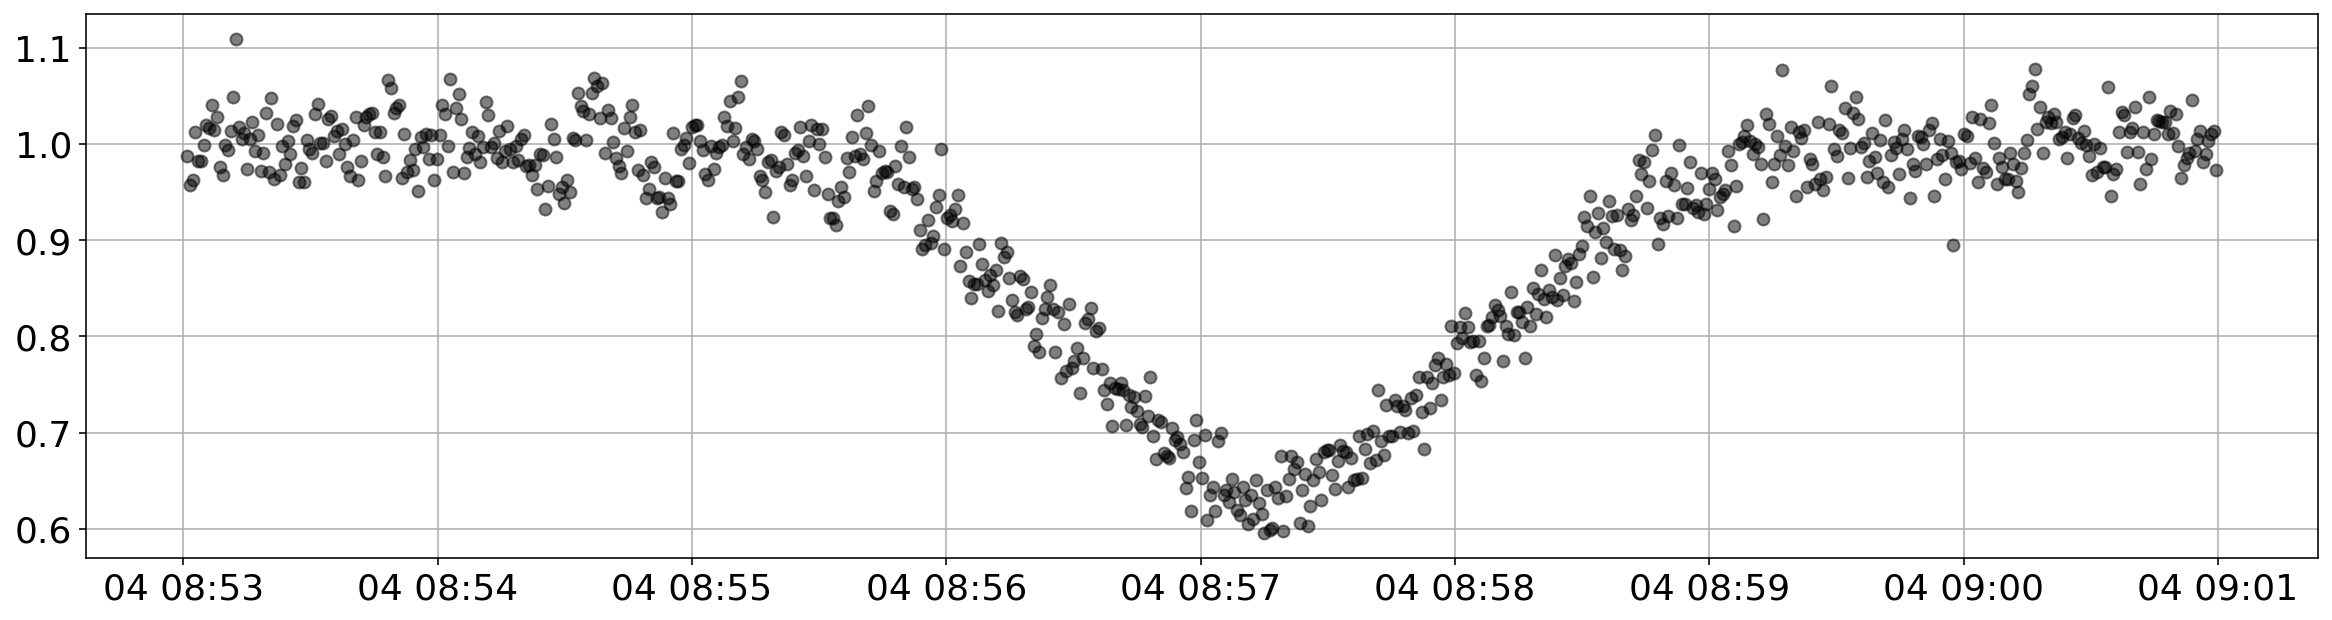

In [3]:
ts = lc_occ[0]

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(ts.time.datetime, ts["flux"], "ko", alpha=0.5)
ax.grid()
ts.time.iso[0]

In [4]:
def get_satellite_positions(epochs):
    """
    Returns the positions of Gallilean satellites relative to Jupiter in (RA, DEC) space
    for the selected epochs.
    """
    jup = Horizons(id="599", epochs=epochs, id_type="id")
    io = Horizons(id="501", epochs=epochs, id_type="id")
    europa = Horizons(id="502", epochs=epochs, id_type="id")
    ganymede = Horizons(id="503", epochs=epochs, id_type="id")
    callisto = Horizons(id="504", epochs=epochs, id_type="id")

    # Compute positions of the satellites relative to Jupiter in (RA, DEC) space
    jup_pos = jup.ephemerides(quantities=1, extra_precision=True)
    io_pos = io.ephemerides(quantities=1, extra_precision=True)
    europa_pos = europa.ephemerides(quantities=1, extra_precision=True)
    ganymede_pos = ganymede.ephemerides(quantities=1, extra_precision=True)
    callisto_pos = callisto.ephemerides(quantities=1, extra_precision=True)

    timestamps = jup.ephemerides()["datetime_jd"]

    io_rel_pos = QTable(
        [io_pos["RA"] - jup_pos["RA"], io_pos["DEC"] - jup_pos["DEC"]],
        names=["RA", "DEC"],
    )
    europa_rel_pos = QTable(
        [europa_pos["RA"] - jup_pos["RA"], europa_pos["DEC"] - jup_pos["DEC"]],
        names=["RA", "DEC"],
    )
    ganymede_rel_pos = QTable(
        [ganymede_pos["RA"] - jup_pos["RA"], ganymede_pos["DEC"] - jup_pos["DEC"]],
        names=["RA", "DEC"],
    )
    callisto_rel_pos = QTable(
        [callisto_pos["RA"] - jup_pos["RA"], callisto_pos["DEC"] - jup_pos["DEC"]],
        names=["RA", "DEC"],
    )

    io_rel_pos["RA"].unit = u.deg
    europa_rel_pos["RA"].unit = u.deg
    ganymede_rel_pos["RA"].unit = u.deg
    callisto_rel_pos["RA"].unit = u.deg

    io_rel_pos["DEC"].unit = u.deg
    europa_rel_pos["DEC"].unit = u.deg
    ganymede_rel_pos["DEC"].unit = u.deg
    callisto_rel_pos["DEC"].unit = u.deg

    return [timestamps, io_rel_pos, europa_rel_pos, ganymede_rel_pos, callisto_rel_pos]


def get_satellite_distances(epochs):
    """
    Returns distances of (Jupiter, Io, Europa, Ganymede, Callisto) w.r.t Earth for selected epochs. 
    """
    earth = Horizons(id="399", epochs=epochs, id_type="id")
    jup = Horizons(id="599", epochs=epochs, id_type="id")
    io = Horizons(id="501", epochs=epochs, id_type="id")
    europa = Horizons(id="502", epochs=epochs, id_type="id")
    ganymede = Horizons(id="503", epochs=epochs, id_type="id")
    callisto = Horizons(id="504", epochs=epochs, id_type="id")

    # Cartesian vectors
    earth_vec = earth.vectors()
    jup_vec = jup.vectors()
    io_vec = io.vectors()
    europa_vec = europa.vectors()
    ganymede_vec = ganymede.vectors()
    callisto_vec = callisto.vectors()

    def compute_distance(r1, r2):
        return (
            np.sqrt(
                (r2["x"] - r1["x"]) ** 2
                + (r2["y"] - r1["y"]) ** 2
                + (r2["z"] - r1["z"]) ** 2
            )
            * u.au
        )

    jup_distance = compute_distance(earth_vec, jup_vec)
    io_distance = compute_distance(earth_vec, io_vec)
    europa_distance = compute_distance(earth_vec, europa_vec)
    ganymede_distance = compute_distance(earth_vec, ganymede_vec)
    callisto_distance = compute_distance(earth_vec, callisto_vec)

    return [
        jup_distance,
        io_distance,
        europa_distance,
        ganymede_distance,
        callisto_distance,
    ]


# Observation times
epochs = {"start": "2009-12-04T08:53:00", "stop": "2009-12-04T09:00:00", "step": "1m"}

timestamps, pos_io, pos_europa, pos_ganymede, pos_callisto = get_satellite_positions(
    epochs
)
dist_jup, dist_io, dist_europa, dist_ganymede, dist_callisto = get_satellite_distances(
    epochs
)

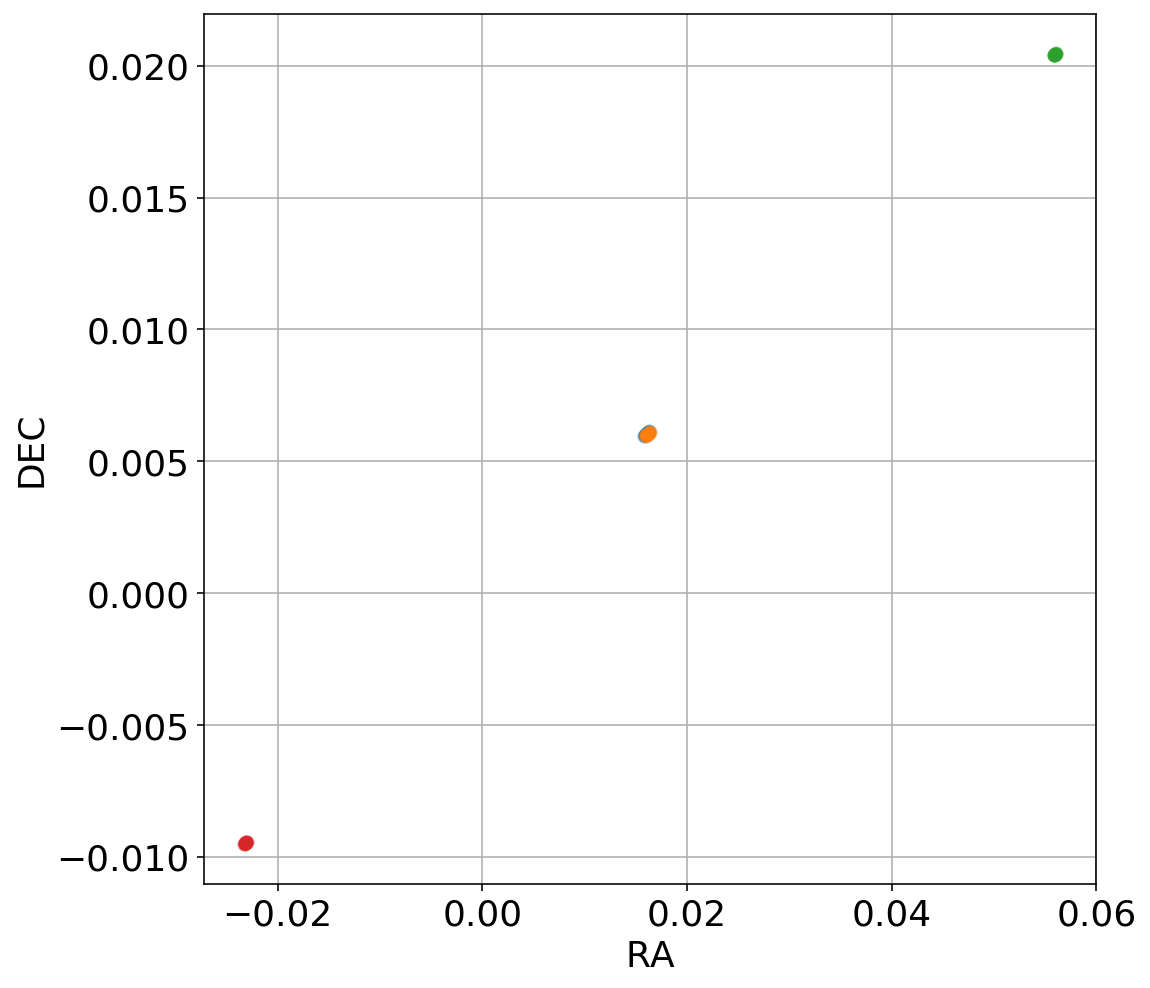

In [5]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(pos_io["RA"], pos_io["DEC"], "C0o", alpha=0.5)
ax.plot(pos_europa["RA"], pos_europa["DEC"], "C1o", alpha=0.5)
ax.plot(pos_ganymede["RA"], pos_ganymede["DEC"], "C2o", alpha=0.5)
ax.plot(pos_callisto["RA"], pos_callisto["DEC"], "C3o", alpha=0.5)
ax.set_xlabel("RA")
ax.set_ylabel("DEC")

ax.grid()

'2009-12-04T08:56:00.000'

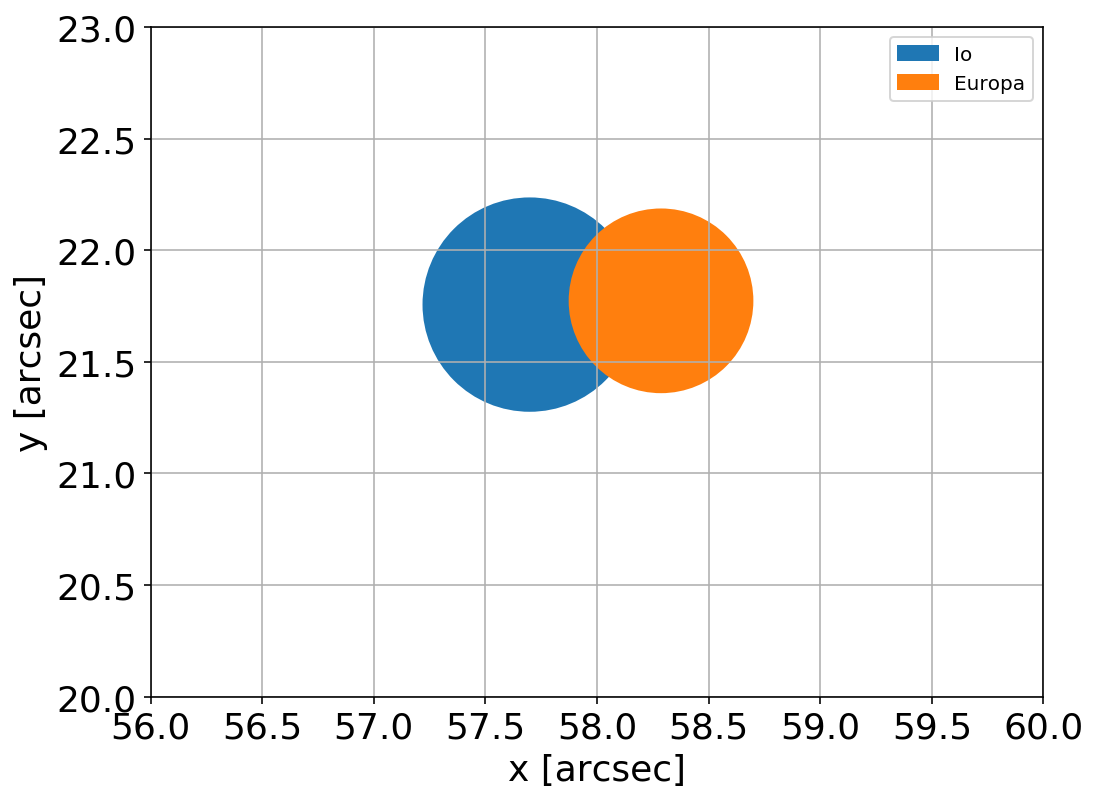

In [6]:
ang_radius_jup = (69911 * u.km / dist_jup.to(u.km)) * u.rad
ang_radius_io = (1821.3 * u.km / dist_io.to(u.km)) * u.rad
ang_radius_europa = (1565.0 * u.km / dist_europa.to(u.km)) * u.rad
ang_radius_ganymede = (2634.0 * u.km / dist_ganymede.to(u.km)) * u.rad
ang_radius_callisto = (2403.0 * u.km / dist_callisto.to(u.km)) * u.rad


def plot_circles(ax, r1, r2, rad1, rad2):
    c1 = plt.Circle((r1[0], r1[1]), rad1, color="C0")
    c2 = plt.Circle((r2[0], r2[1]), rad2, color="C1")

    ax.add_artist(c1)
    ax.add_artist(c2)

    ax.legend([c1, c2], ["Io", "Europa"])


fig, ax = plt.subplots(figsize=(8, 8))

idx = 3

plot_circles(
    ax,
    [pos_io["RA"][idx].to(u.arcsec).value, pos_io["DEC"][idx].to(u.arcsec).value],
    [
        pos_europa["RA"][idx].to(u.arcsec).value,
        pos_europa["DEC"][idx].to(u.arcsec).value,
    ],
    ang_radius_io[idx].to(u.arcsec).value,
    ang_radius_europa[idx].to(u.arcsec).value,
)

ax.set_ylim(20, 23)
ax.set_xlim(56, 60)
ax.set_aspect(1)
ax.grid()
ax.set_xlabel("x [arcsec]")
ax.set_ylabel("y [arcsec]")
Time(timestamps[idx], format="jd").isot

### Comparison to IMCCE multisat ephemeris

In [7]:
eph_jup = np.genfromtxt("imcce_calculator_jupiter.txt")
eph_io = np.genfromtxt("imcce_calculator_io.txt")
eph_europa = np.genfromtxt("imcce_calculator_europa.txt")

times = TimeSeries(time=Time(eph_jup[:, 0], format="mjd"))

ra_jup = eph_jup[:, 1] * 360 / 24 * u.deg
dec_jup = eph_jup[:, 2] * u.deg

ra_io = eph_io[:, 1] * 360 / 24 * u.deg
dec_io = eph_io[:, 2] * u.deg

ra_europa = eph_europa[:, 1] * 360 / 24 * u.deg
dec_europa = eph_europa[:, 2] * u.deg

ra_io_rel = ra_io - ra_jup
dec_io_rel = dec_io - dec_jup

ra_europa_rel = ra_europa - ra_jup
dec_europa_rel = dec_europa - dec_jup

Text(0.5, 1.0, 'Difference in ephemeris between JPL Horizons and IMCCE Multisat')

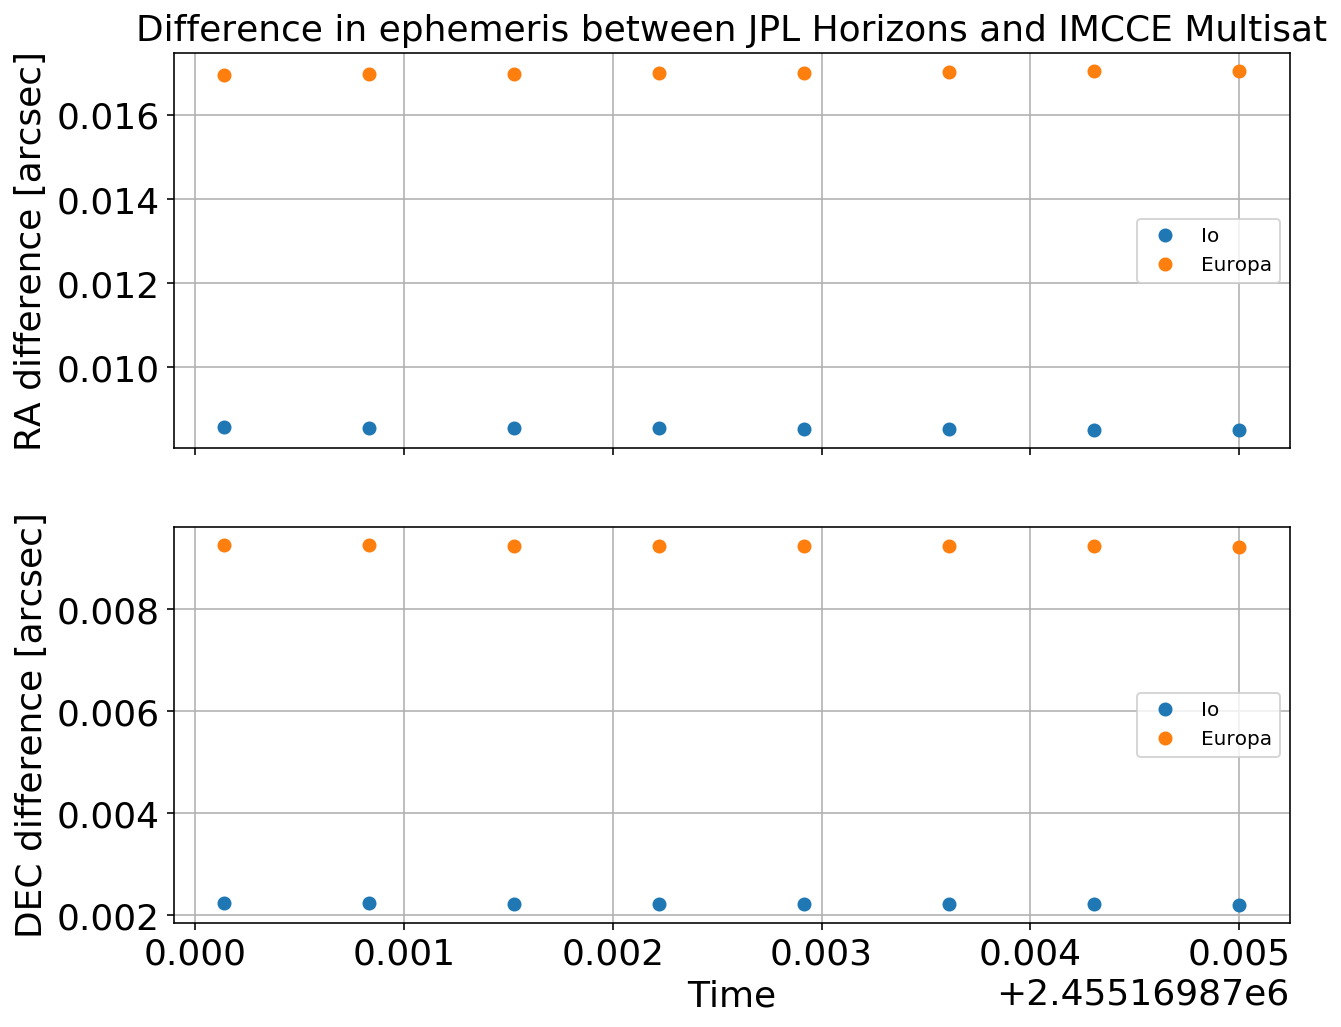

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

ax[0].plot(
    times.time.mjd,
    pos_io["RA"].to(u.arcsec).value - ra_io_rel.to(u.arcsec).value,
    "C0o",
    label="Io",
)
ax[0].plot(
    times.time.mjd,
    pos_europa["RA"].to(u.arcsec).value - ra_europa_rel.to(u.arcsec).value,
    "C1o",
    label="Europa",
)
ax[1].plot(
    times.time.mjd,
    pos_io["DEC"].to(u.arcsec).value - dec_io_rel.to(u.arcsec).value,
    "C0o",
    label="Io",
)
ax[1].plot(
    times.time.mjd,
    pos_europa["DEC"].to(u.arcsec).value - dec_europa_rel.to(u.arcsec).value,
    "C1o",
    label="Europa",
)


ax[0].set_ylabel("RA difference [arcsec]")
ax[1].set_ylabel("DEC difference [arcsec]")

ax[1].set_xlabel("Time")

for a in ax.flatten():
    a.grid()
    a.legend()


ax[0].set_title("Difference in ephemeris between JPL Horizons and IMCCE Multisat")

### Illumination of Io as a function of time

In [9]:
# Observation times
epochs = {"start": "2002-12-04", "stop": "2003-12-04", "step": "6h"}

io = Horizons(id="501", epochs=epochs, id_type="id")
io_eph = io.ephemerides()
io_eph.info

<Table masked=True length=1461>
      name        dtype       unit     n_bad
---------------- ------- ------------- -----
      targetname    str8           ---     0
    datetime_str   str17           ---     0
     datetime_jd float64             d     0
  solar_presence    str1           ---     0
           flags    str1           ---     0
              RA float64           deg     0
             DEC float64           deg     0
          RA_app float64           deg     0
         DEC_app float64           deg     0
         RA_rate float64    arcsec / h     0
        DEC_rate float64    arcsec / h     0
              AZ   int64           deg  1461
              EL   int64           deg  1461
         AZ_rate   int64  arcsec / min  1461
         EL_rate   int64  arcsec / min  1461
           sat_X float64        arcsec     0
           sat_Y float64        arcsec     0
        sat_PANG float64           deg     0
    siderealtime   int64           ---  1461
         airmass   int6

![](http://win98.altervista.org/space/exploration/Q15.png)

In [10]:
# Cartesian vectors
earth = Horizons(id="399", epochs=epochs, id_type="id")

earth_vec = earth.vectors()
io_vec = io.vectors()


def compute_distance(r1, r2):
    return (
        np.sqrt(
            (r2["x"] - r1["x"]) ** 2
            + (r2["y"] - r1["y"]) ** 2
            + (r2["z"] - r1["z"]) ** 2
        )
        * u.au
    )


io_distance = compute_distance(earth_vec, io_vec)

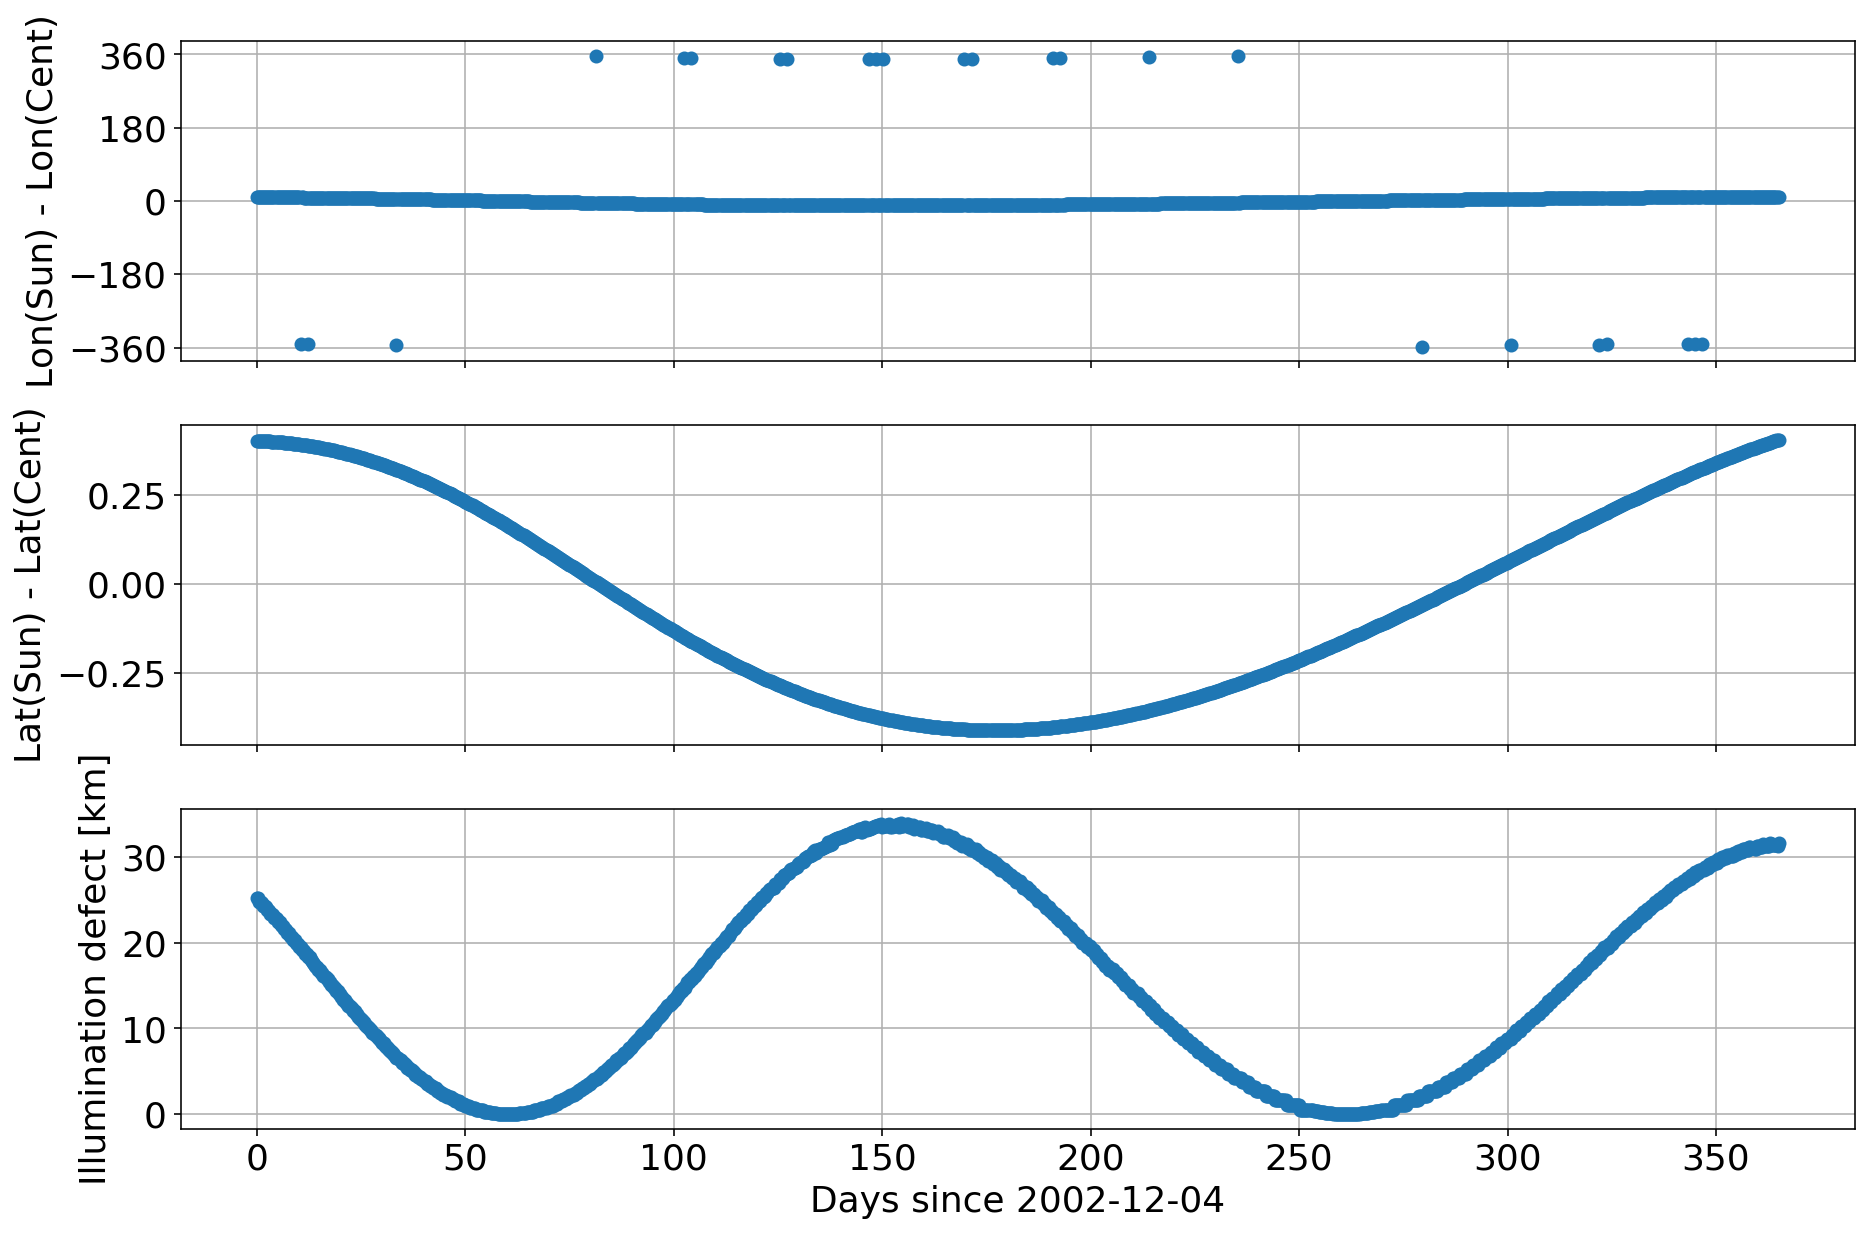

In [11]:
fig, ax = plt.subplots(3, 1, figsize=(15, 10), sharex=True)
ax[0].plot(
    io_eph["datetime_jd"] - io_eph["datetime_jd"][0],
    io_eph["PDSunLon"] - io_eph["PDObsLon"],
    "C0o",
)

ax[0].set_yticks([-360, -180, 0, 180, 360])

ax[0].set_ylabel("Lon(Sun) - Lon(Cent)")

ax[1].plot(
    io_eph["datetime_jd"] - io_eph["datetime_jd"][0],
    io_eph["PDSunLat"] - io_eph["PDObsLat"],
    "C0o",
)
# ax[1].set_yticks([0, 90, 180, 270, 360])
ax[1].set_ylabel("Lat(Sun) - Lat(Cent)")

ax[2].plot(
    io_eph["datetime_jd"] - io_eph["datetime_jd"][0],
    io_eph["illum_defect"].to(u.rad) * io_distance.to(u.km),
    "C0o",
)
# ax[1].set_yticks([0, 90, 180, 270, 360])
ax[2].set_ylabel("Illumination defect [km]")

ax[2].set_xlabel(f"Days since {epochs['start']}")

# ax[0].set_ylim(-12, 12)
# ax[0].set_yticks(np.arange(-12, 14,  4))


for a in ax.flatten():
    a.grid()

Pre-computing some matrices... Done.
Compiling `render`... /Users/fbartolic/anaconda3/envs/io/lib/python3.8/site-packages/theano/gof/cc.py:968: UserWarning: Your g++ compiler fails to compile OpenMP code. We know this happen with some version of the EPD mingw compiler and LLVM compiler on Mac OS X. We disable openmp everywhere in Theano. To remove this warning set the theano flags `openmp` to False.
  ret += x.c_compile_args()
Done.


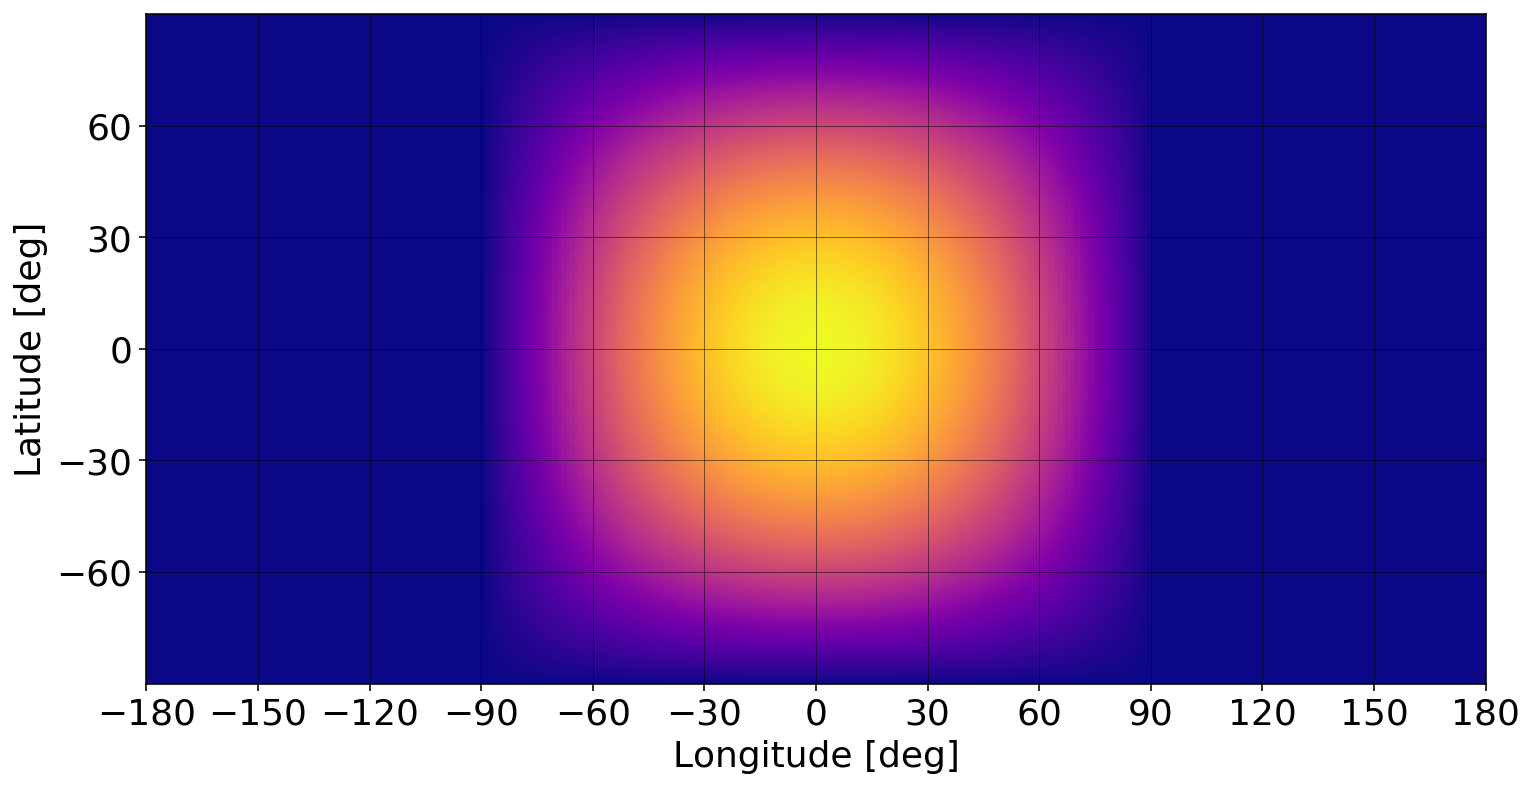

In [12]:
import starry

starry.config.lazy = False

map = starry.Map(ydeg=0, reflected=True)

fig, ax = plt.subplots(figsize=(12, 7))
map.show(ax=ax, projection="rect")

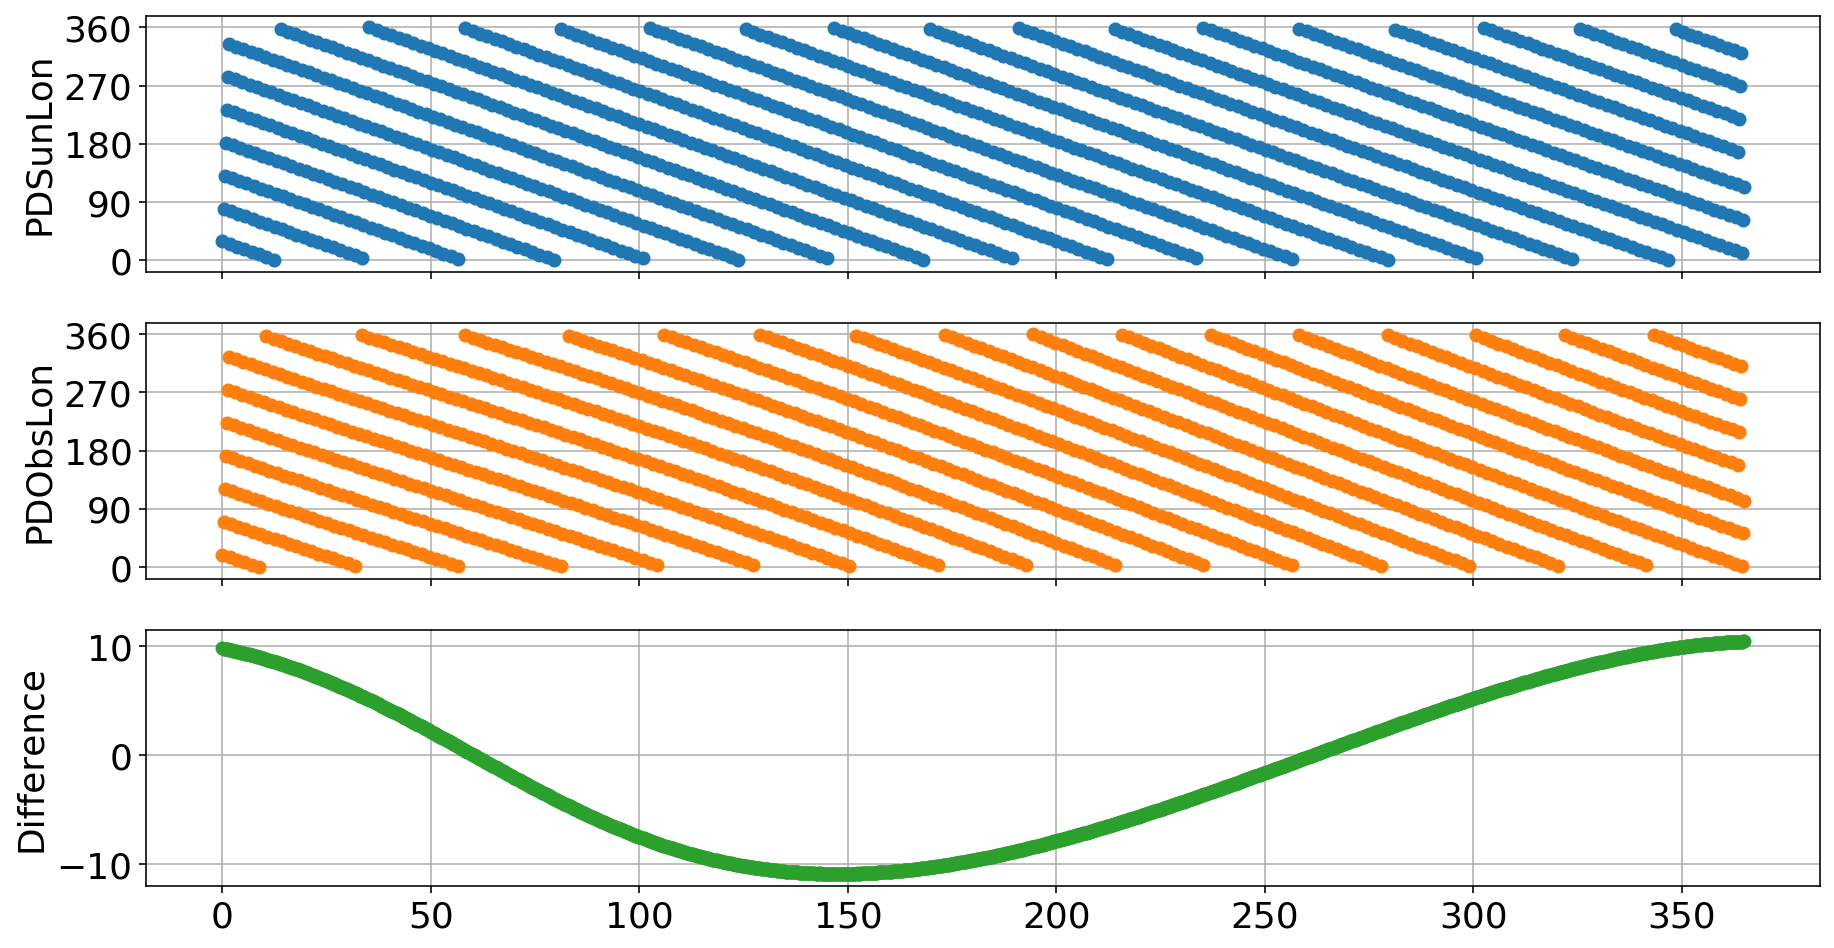

In [13]:
io_cent_lon = io_eph["PDObsLon"].to(u.rad)
io_cent_lat = io_eph["PDObsLat"].to(u.rad)

subsolar_lon = io_eph["PDSunLon"].to(u.rad)
subsolar_lat = io_eph["PDSunLat"].to(u.rad)

# Get Longitude of Sun relative to central point of Io, same for Latitude
subtract_angles = lambda x, y: np.fmod((x - y) + np.pi * 3, 2 * np.pi) - np.pi

subsolar_lon_diff = subtract_angles(np.array(subsolar_lon), np.array(io_cent_lon))
subsolar_lat_diff = subtract_angles(np.array(subsolar_lat), np.array(io_cent_lat))

ig, ax = plt.subplots(3, 1, figsize=(15, 8), sharex=True)

ax[0].plot(
    io_eph["datetime_jd"] - io_eph["datetime_jd"][0], subsolar_lon * 180 / np.pi, "C0o"
)
ax[0].set_ylabel("PDSunLon")
ax[1].plot(
    io_eph["datetime_jd"] - io_eph["datetime_jd"][0], io_cent_lon * 180 / np.pi, "C1o"
)
ax[1].set_ylabel("PDObsLon")
ax[2].plot(
    io_eph["datetime_jd"] - io_eph["datetime_jd"][0],
    subsolar_lon_diff * 180 / np.pi,
    "C2o",
)
ax[2].set_ylabel("Difference")

ax[0].set_yticks([0, 90, 180, 270, 360])
ax[1].set_yticks([0, 90, 180, 270, 360])

for a in ax.ravel():
    a.grid()

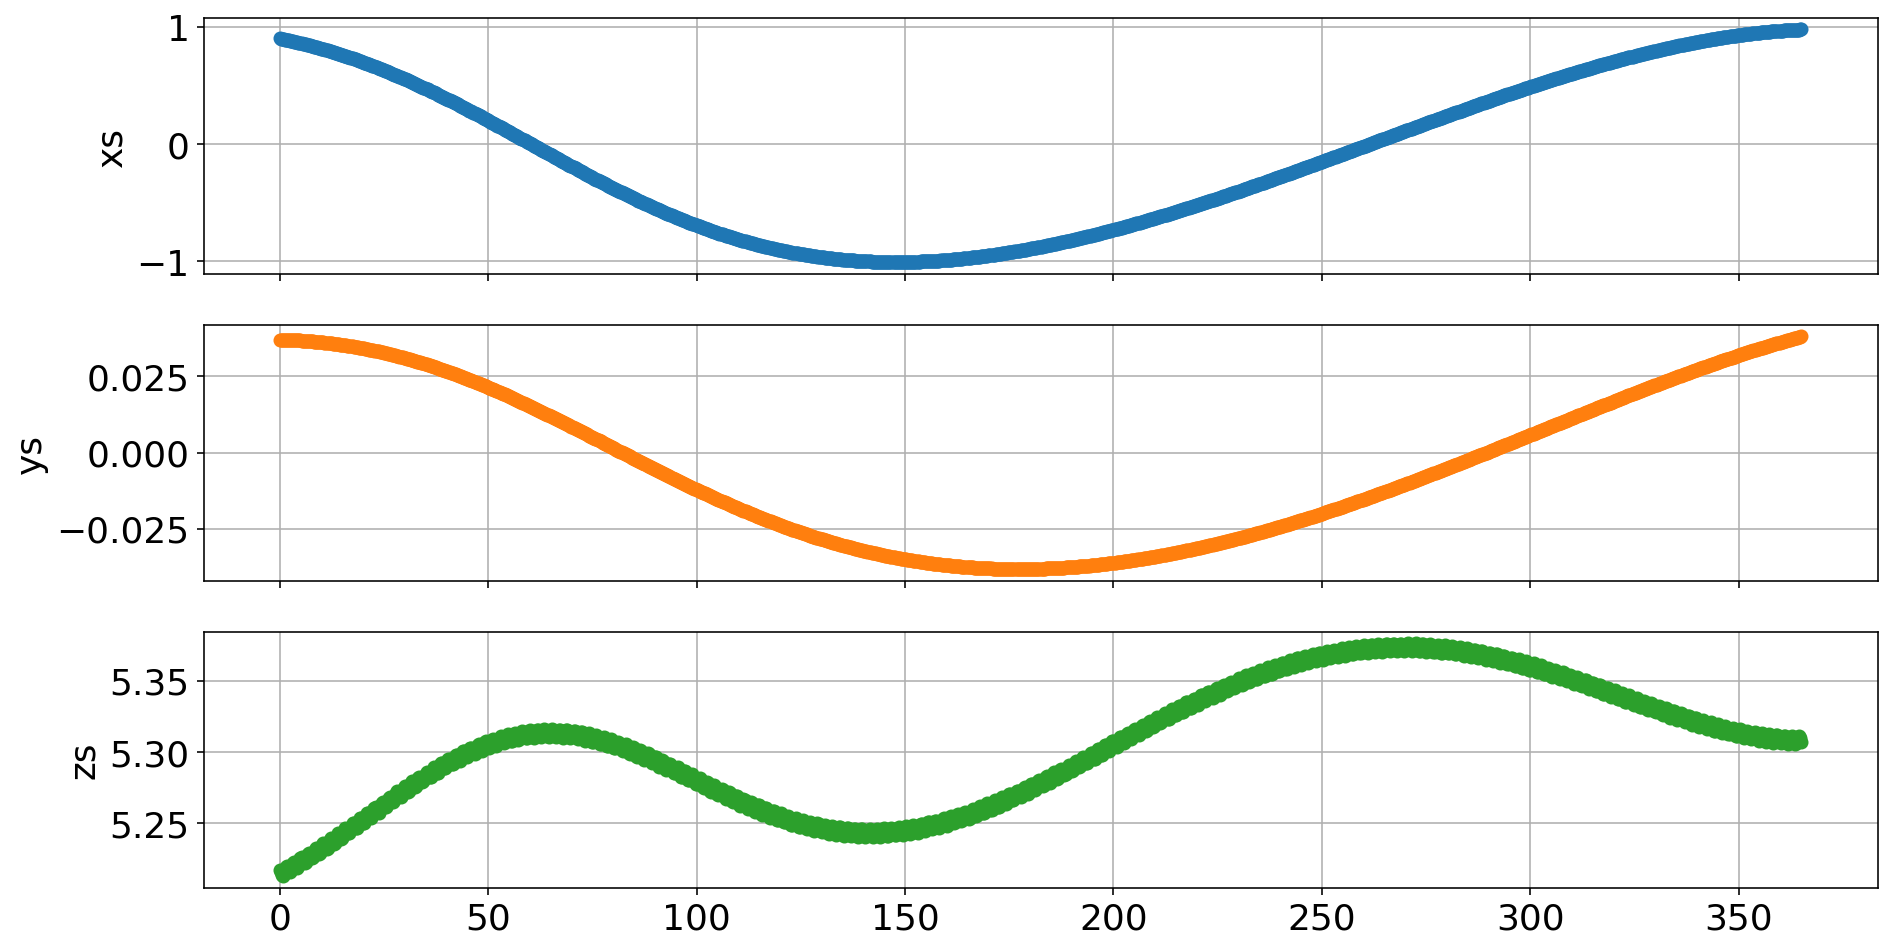

In [14]:
# Convert to cartesian coordinates used in Starry
xs = np.array(io_eph["r"]) * np.cos(subsolar_lat_diff) * np.sin(subsolar_lon_diff)
ys = np.array(io_eph["r"]) * np.sin(subsolar_lat_diff)
zs = np.array(io_eph["r"]) * np.cos(subsolar_lat_diff) * np.cos(subsolar_lon_diff)

fig, ax = plt.subplots(3, 1, figsize=(15, 8), sharex=True)
ax[0].plot(io_eph["datetime_jd"] - io_eph["datetime_jd"][0], xs, "C0o")
ax[1].plot(io_eph["datetime_jd"] - io_eph["datetime_jd"][0], ys, "C1o")
ax[2].plot(io_eph["datetime_jd"] - io_eph["datetime_jd"][0], zs, "C2o")
ax[0].set_ylabel("xs")
ax[1].set_ylabel("ys")
ax[2].set_ylabel("zs")

for a in ax.flatten():
    a.grid()

Pre-computing some matrices... Done.
Compiling `render`... Done.


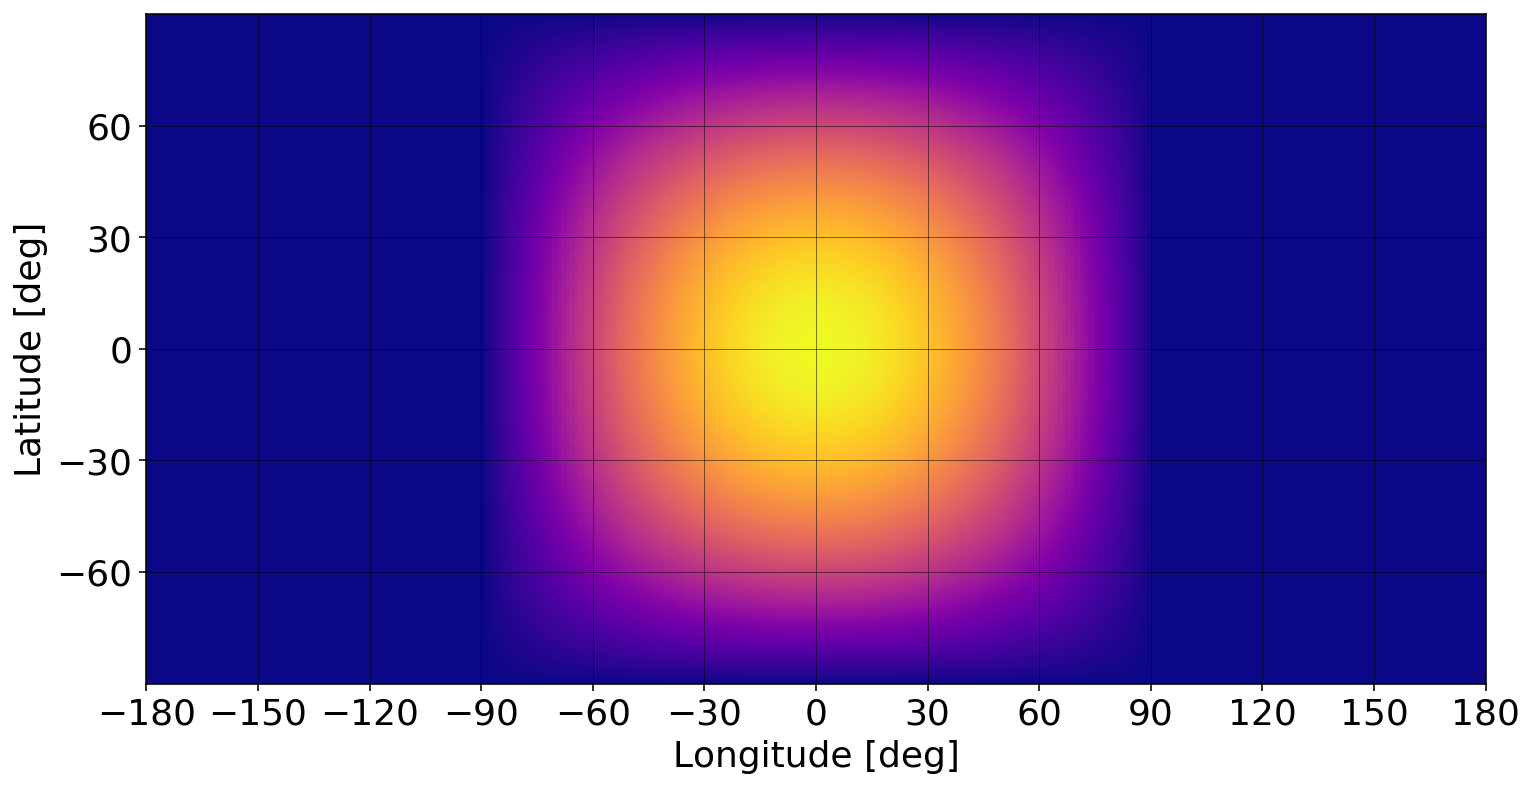

In [23]:
import starry

starry.config.lazy = False

map = starry.Map(ydeg=0, reflected=True)

fig, ax = plt.subplots(figsize=(12, 7))
map.show(ax=ax, projection="rect")

fig, ax = plt.subplots(figsize=(8, 8))

map.obl = -20
map.inc = 90 - 20
map.show(ax=ax, xs=xs[::5], ys=ys[::5], zs=zs[::5])

In [16]:
# Observation times
epochs = {"start": "2002-12-04", "stop": "2005-12-04", "step": "2d"}

io = Horizons(id="501", epochs=epochs, id_type="id")
jup = Horizons(id="599", epochs=epochs, id_type="id")

io_eph = io.ephemerides()
io_eph[["NPole_ang", "NPole_RA", "NPole_DEC"]]
jup_eph = jup.ephemerides()
jup_eph[["NPole_ang", "NPole_RA", "NPole_DEC"]]

NPole_ang,NPole_RA,NPole_DEC
deg,deg,deg
float64,float64,float64
20.0299,268.05635,64.49596
20.0296,268.05635,64.49596
20.0258,268.05634,64.49596
20.0183,268.05634,64.49596
20.0072,268.05634,64.49596
19.9924,268.05634,64.49596
19.974,268.05634,64.49596
19.9521,268.05634,64.49596


In [17]:
jup_eph = jup.ephemerides()
jup_eph[["NPole_ang", "NPole_RA", "NPole_DEC"]]

NPole_ang,NPole_RA,NPole_DEC
deg,deg,deg
float64,float64,float64
20.0299,268.05635,64.49596
20.0296,268.05635,64.49596
20.0258,268.05634,64.49596
20.0183,268.05634,64.49596
20.0072,268.05634,64.49596
19.9924,268.05634,64.49596
19.974,268.05634,64.49596
19.9521,268.05634,64.49596


Text(0.5, 0, 'Days since 2002-12-04')

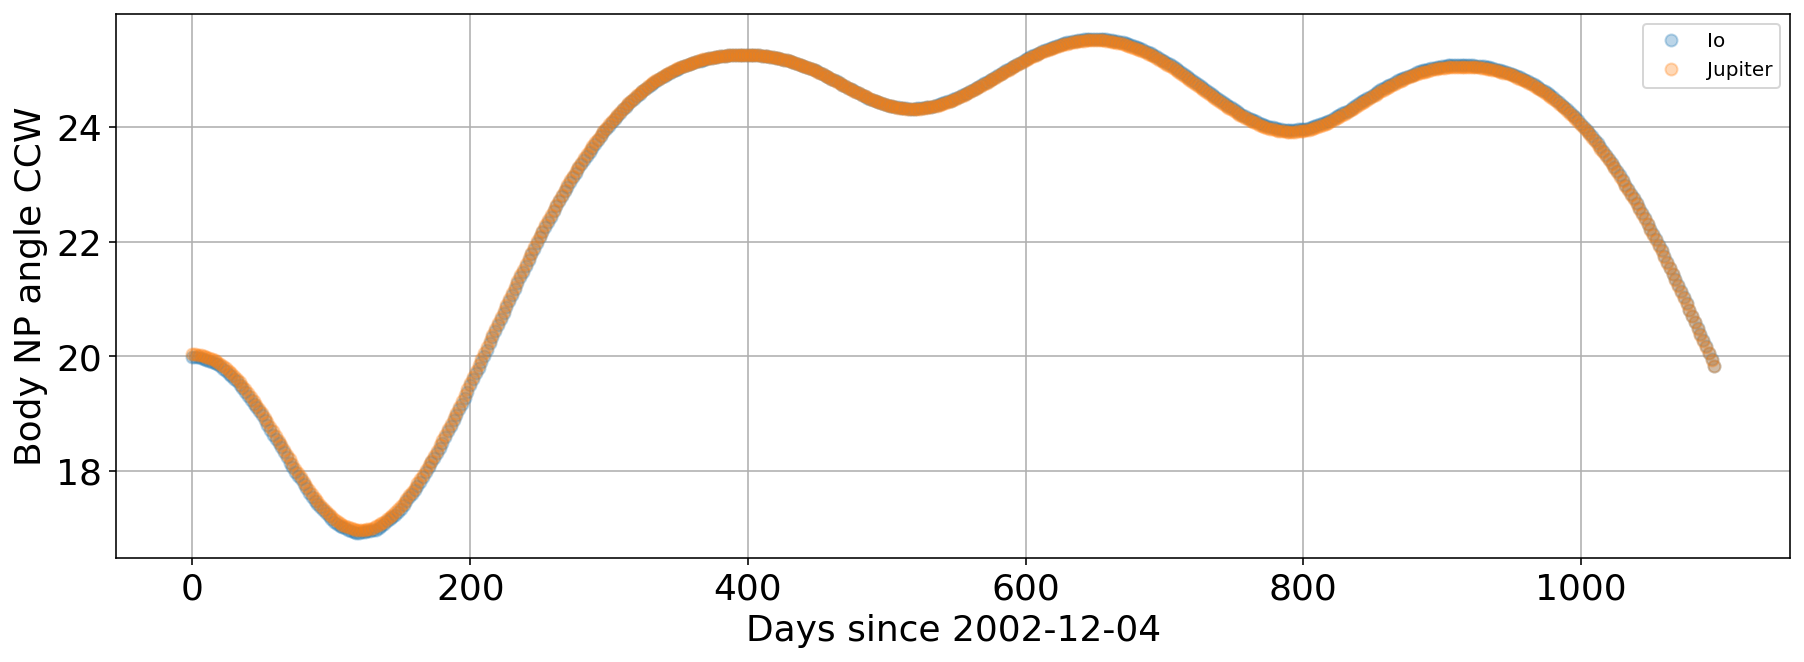

In [18]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(
    io_eph["datetime_jd"] - io_eph["datetime_jd"][0],
    io_eph["NPole_ang"],
    "C0o",
    label="Io",
    alpha=0.3,
)
ax.plot(
    io_eph["datetime_jd"] - io_eph["datetime_jd"][0],
    jup_eph["NPole_ang"],
    "C1o",
    label="Jupiter",
    alpha=0.3,
)

ax.grid()
ax.legend()
ax.set_ylabel("Body NP angle CCW")
ax.set_xlabel(f"Days since {epochs['start']}")

In [19]:
def get_starry_map_orientation(times, body_id="501", step="1m"):
    """
    Given a NAIF code of a Solar System body, this function computes the position and orientation of 
    the body in equatorial coordinates at requested times using ephemeris from JPL Horizons. The relevant
    JPL Horizons data is the following:
    
    'RA', 'DEC'
    ###########
    Position on the plane of the sky.
    
    'ang_width'
    ###########
    The angle subtended by the disk of the target seen by the observer, if
    it was fully illuminated. The target diameter is taken to be the IAU2009
    equatorial diameter. Oblateness aspect is not currently included.
    Units: ARCSECONDS
    
    'sat_vis'
    #########
    The angle between the center of a non-lunar target body and the center
    of the primary body it revolves around, as seen by the observer.
    Units: ARCSECONDS

    Non-lunar natural satellite visibility codes (limb-to-limb):

    /t = Transitting primary body disk, /O = Occulted by primary body disk,
    /p = Partial umbral eclipse,        /P = Occulted partial umbral eclipse,
    /u = Total umbral eclipse,          /U = Occulted total umbral eclipse,
    /- = Target is the primary body,    /* = None of above ("free and clear")

    ... the radius of major bodies is taken to be the equatorial value (max)
    defined by the IAU2009 system. Atmospheric effects and oblateness aspect
    are not currently considered in these computations. Light-time is included.

    'illum_defect'
    ##############
    Angular width of target circular disk diameter NOT illuminated by Sun.
    Available only if target radius is known.  Units: ARCSECONDS
    
    'r'
    ###
    Heliocentric range ("r", light-time compensated) and range-rate ("rdot")
    of the target point at the instant light later seen by the observer at
    print-time would have left the target (at the instant print-time minus
    down-leg light-time); the Sun-to-target distance traveled by a ray of
    light emanating from the center of the Sun that reaches the target at some
    instant and is recordable by the observer one down-leg light-time later at
    print-time. "rdot" is a projection of the velocity vector along this ray,
    the light-time-corrected line-of-sight from the Sun's center, and indicates
    relative motion. A positive "rdot" means the target is moving away from
    the Sun. A negative "rdot" means the target is moving toward the Sun.
    Units: AU or KM, KM/S
    
    'PDObsLong', 'PDObsLat'
    #######################
    Apparent planetodetic ("geodetic") longitude and latitude (IAU2009
    model) of the center of the target seen by the OBSERVER at print-time.
    This is NOT exactly the same as the "sub-observer" (nearest) point for
    a non-spherical target shape, but is generally very close if not a highly
    irregular body shape. Light travel-time from target to observer is taken
    into account. Latitude is the angle between the equatorial plane and the
    line perpendicular to the reference ellipsoid of the body. The reference
    ellipsoid is an oblate spheroid with a single flatness coefficient in
    which the y-axis body radius is taken to be the same value as the x-axis
    radius. For the gas giants only (Jupiter, Saturn, Uranus and Neptune),
    these longitudes are based on the Set III prime meridian angle, referred
    to the planet's rotating magnetic field. Latitude is always referred to
    the body dynamical equator.  Note there can be an offset between the
    dynamical pole and the magnetic pole. The direction of positive longitude
    (east or west) will be indicated in the description at the end of the
    requested ephemeris.  Units: DEGREES
    
    'PDSunLong', 'PDSunLat'
    #######################
    Solar sub-long & sub-lat
    Apparent planetodetic ("geodetic") longitude and latitude of the Sun
    (IAU2009) as seen by the observer at print-time.  This is NOT exactly the
    same as the "sub-solar" (nearest) point for a non-spherical target shape,
    but is generally very close if not a highly irregular body shape. Light
    travel-time from Sun to target and from target to observer is taken into
    account.  Latitude is the angle between the equatorial plane and the line
    perpendicular to the reference ellipsoid of the body. The reference
    ellipsoid is an oblate spheroid with a single flatness coefficient in
    which the y-axis body radius is taken to be the same value as the x-axis
    radius. For the gas giants only (Jupiter, Saturn, Uranus and Neptune),
    these longitudes are based on the Set III prime meridian angle, referred
    to the planet's rotating magnetic field. Latitude is always referred to
    the body dynamical equator. Note there can be an offset between the
    dynamical pole and the magnetic pole. The direction of positive longitude
    (east or west) will be indicated in the descripton at the end of the
    requested ephemeris. Units: DEGREES
    
    'NPole_ang'
    ###########
    Target's North Pole position angle (CCW with respect to direction of
    true-of-date Celestial North Pole) and angular distance from the
    "sub-observer" point (center of disk) at print time. Negative distance
    indicates N.P. on hidden hemisphere. Units: DEGREES and ARCSECONDS
    
    Parameters
    ----------
    body_id : str
        NAIF code for the target body. By default '501' for Io.
    times: astropy.time
        Observation times. 
        
    Returns
    -------
    astropy.timeseries.TimeSeries
        An astropy.TimeSeries object with entries relevant for defining the orientation of
        a Starry map at any given time. All quantities are interpolated from the JPL Horizons
        data to the requested times. The columns are the following: RA [arcsec], DEC [arcsec],
        inc [deg], obl [deg], theta [deg], xs [AU], ys[AU], zs[AU], par_ecl[bool],
        tot_ecl[bool], occ_primary[bool] where the (xs, ys, zs) are the Cartesian coordinates
        of the Sun w.r. to target body as seen from Earth. Boolean flag 'par_ecl' is True 
        whenever the target body is in a partial eclipse with respect to its primary and similarly
        for a total eclipse. The flag 'occ_primary' is True whenever the target body is occulted
        by the primary. In the case of multiple satellites this flag won't capture mutual
        occultations between the satellites.
    """

    start = times.isot[0]

    # because Horizons time range doesn't include the endpoint we need to add some extra time
    if step[-1] == "m":
        padding = 2 * float(step[:-1]) / (60 * 24)
    elif step[-1] == "h":
        padding = 2 * float(step[:-1]) / 24
    elif step[-1] == "d":
        padding = 2 * float(step[:-1])
    else:
        raise ValueError(
            "Unrecognized JPL Horizons step size. Use '1m' or '1h' for example."
        )

    end = Time(times.mjd[-1] + padding, format="mjd").isot

    # Query JPL Horizons
    epochs = {"start": start, "stop": end, "step": step}
    obj = Horizons(id="501", epochs=epochs, id_type="id")
    eph = obj.ephemerides(quantities="1,11,12,13,14,15,17, 19", extra_precision=True)
    times_jpl = Time(eph["datetime_jd"], format="jd")

    # Store all data in a TimeSeries object
    data = TimeSeries(time=times)

    data["RA"] = np.interp(times.mjd, times_jpl.mjd, eph["RA"]) * eph["RA"].unit
    data["DEC"] = np.interp(times.mjd, times_jpl.mjd, eph["DEC"]) * eph["DEC"].unit
    data["ang_width"] = (
        np.interp(times.mjd, times_jpl.mjd, eph["ang_width"]) * eph["ang_width"].unit
    )
    data["illum_defect"] = (
        np.interp(times.mjd, times_jpl.mjd, eph["illum_defect"])
        * eph["illum_defect"].unit
    )
    data["par_ecl"] = np.array(
        np.interp(times.mjd, times_jpl.mjd, eph["sat_vis"] == "p"), dtype=bool
    )
    data["tot_ecl"] = np.array(
        np.interp(times.mjd, times_jpl.mjd, eph["sat_vis"] == "u"), dtype=bool
    )
    data["occ_primary"] = np.array(
        np.interp(times.mjd, times_jpl.mjd, eph["sat_vis"] == "O"), dtype=bool
    )

    # Helper functions for dealing with angles and discontinuities
    subtract_angles = lambda x, y: np.fmod((x - y) + np.pi * 3, 2 * np.pi) - np.pi

    def interpolate_angle(x, xp, yp):
        """Interpolate an angular quantity on domain [-pi, pi) and avoid discountinuities."""
        cosy = np.interp(x, xp, np.cos(yp))
        siny = np.interp(x, xp, np.sin(yp))

        return np.arctan2(siny, cosy)

    # Inclination of the starry map = 90 - latitude of the central point of the observed disc
    data["inc"] = interpolate_angle(
        times.mjd, times_jpl.mjd, np.pi / 2 * u.rad - eph["PDObsLat"].to(u.rad)
    ).to(u.deg)

    # Rotational phase of the starry map is the observer longitude
    data["theta"] = (
        interpolate_angle(times.mjd, times_jpl.mjd, eph["PDObsLon"].to(u.rad)).to(u.deg)
        + 180 * u.deg
    )

    # Obliquity of the starry map is minus the CCW angle from the celestial NP to the NP of the target body
    data["obl"] = interpolate_angle(
        times.mjd, times_jpl.mjd, -eph["NPole_ang"].to(u.rad)
    ).to(u.deg)

    # Compute the location of the subsolar point relative to the central point of the disc
    lon_subsolar = subtract_angles(
        np.array(eph["PDSunLon"].to(u.rad)), np.array(eph["PDObsLon"].to(u.rad))
    )

    lat_subsolar = subtract_angles(
        np.array(eph["PDSunLat"].to(u.rad)), np.array(eph["PDObsLat"].to(u.rad))
    )

    # Location of the subsolar point in cartesian Starry coordinates
    xs = np.array(eph["r"]) * np.cos(lat_subsolar) * np.sin(lon_subsolar)
    ys = np.array(eph["r"]) * np.sin(lat_subsolar)
    zs = np.array(eph["r"]) * np.cos(lat_subsolar) * np.cos(lon_subsolar)

    data["xs"] = np.interp(times.mjd, times_jpl.mjd, xs) * u.AU
    data["ys"] = np.interp(times.mjd, times_jpl.mjd, ys) * u.AU
    data["zs"] = np.interp(times.mjd, times_jpl.mjd, zs) * u.AU

    return data

In [20]:
times = Time(np.linspace(ts.time.mjd[0], ts.time.mjd[-1] + 10, 10000), format="mjd")

data = get_starry_map_orientation(times, step="5m")
data

time,RA,DEC,ang_width,illum_defect,par_ecl,tot_ecl,occ_primary,inc,theta,obl,xs,ys,zs
,deg,deg,arcsec,arcsec,,,,deg,deg,deg,AU,AU,AU
object,float64,float64,float64,float64,bool,bool,bool,float64,float64,float64,float64,float64,float64
55169.37014966667,323.98906046738546,-15.320407736865924,0.9555749999971962,0.0081,False,False,False,89.67119199999298,212.3380643297478,20.888100000140195,-0.9193823992806753,0.039473181559553476,4.927564910476942
55169.37115032081,323.9892981868001,-15.320325049847344,0.9555732708667366,0.0081,False,False,False,89.67118767716684,212.54143042372385,20.888186456663178,-0.9193779013462425,0.039473225831772506,4.927561697359104
55169.372150974945,323.989535906213,-15.320242362829367,0.9555715417362896,0.0081,False,False,False,89.67118335434073,212.74480028245813,20.88827291318554,-0.9193734034118426,0.03947327010399122,4.927558484241288
55169.373151629086,323.98977362562766,-15.320159675810785,0.95556981260583,0.0081,False,False,False,89.67117903151458,212.94816878458212,20.88835936970852,-0.9193689054774098,0.03947331437621026,4.927555271123449
55169.37415228323,323.9900109752246,-15.32007712810395,0.9555682362294752,0.0081,False,False,False,89.67117470868843,213.1515337604283,20.88843055082101,-0.9193644227939057,0.03947334480982156,4.927551993959491
55169.37515293736,323.9902479969334,-15.3199947039138,0.955566795287436,0.0081,False,False,False,89.67117038586231,213.35490335200114,20.88848818850257,-0.9193599536321586,0.039473362973895205,4.927548660011213
55169.376153591504,323.99048501864394,-15.319912279723049,0.9555653543453863,0.0081,False,False,False,89.67116606303617,213.558273995187,20.88854582618455,-0.9193554844703791,0.039473381137968985,4.92754532606291
55169.377154245645,323.99072199762765,-15.31982987158732,0.9555638960840039,0.0081,False,False,False,89.67116174021,213.76164063087288,20.888603463866534,-0.9193510125715272,0.03947340076369506,4.927541985698586


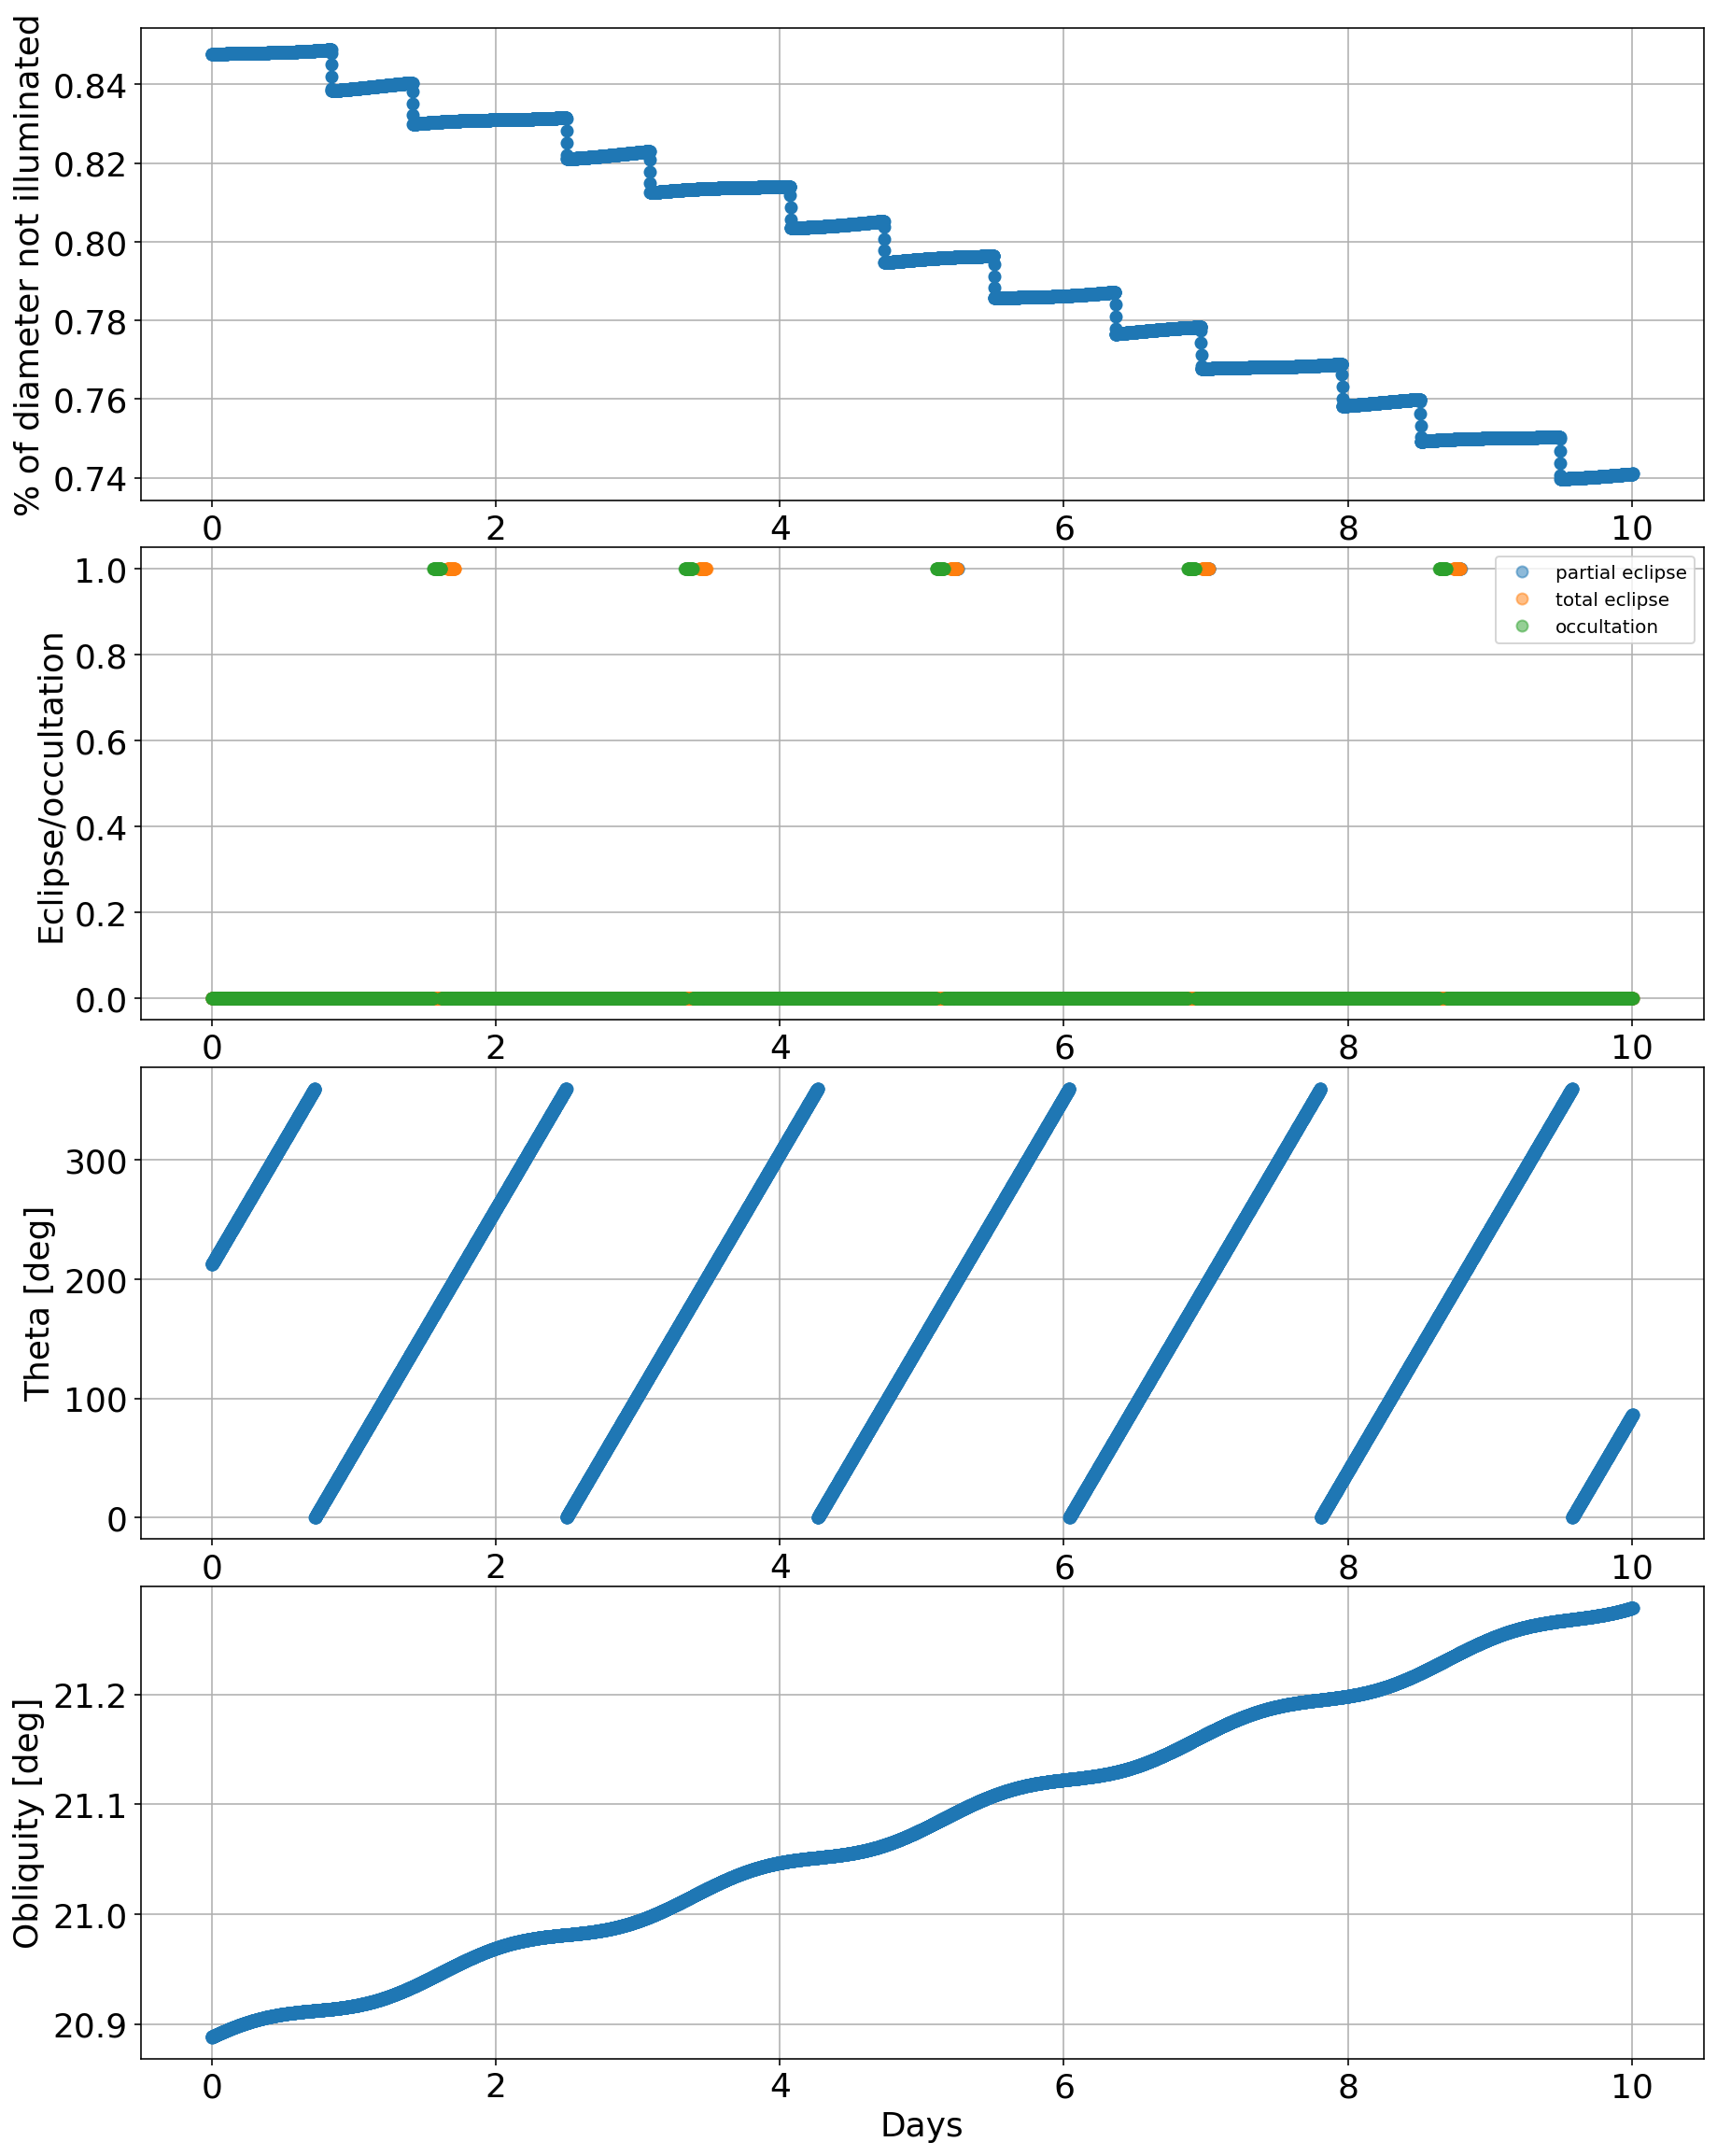

In [21]:
fig, ax = plt.subplots(4, 1, figsize=(15, 20))
fig.subplots_adjust(hspace=0.1)

ax[0].plot(
    data.time.mjd - data.time.mjd[0],
    data["illum_defect"] / data["ang_width"] * 100,
    "C0o",
)
ax[0].set_ylabel("% of diameter not illuminated")

ax[1].plot(
    data.time.mjd - data.time.mjd[0],
    data["par_ecl"],
    "C0o",
    alpha=0.5,
    label="partial eclipse",
)
ax[1].plot(
    data.time.mjd - data.time.mjd[0],
    data["tot_ecl"],
    "C1o",
    alpha=0.5,
    label="total eclipse",
)
ax[1].plot(
    data.time.mjd - data.time.mjd[0],
    data["occ_primary"],
    "C2o",
    alpha=0.5,
    label="occultation",
)
ax[1].legend()
ax[1].set_ylabel("Eclipse/occultation")
ax[2].plot(data.time.mjd - data.time.mjd[0], data["theta"], "C0o")
ax[2].set_ylabel("Theta [deg]")
ax[3].plot(data.time.mjd - data.time.mjd[0], data["obl"], "C0o")
ax[3].set_ylabel("Obliquity [deg]")

ax[-1].set_xlabel("Days")
for a in ax.flatten():
    a.grid()

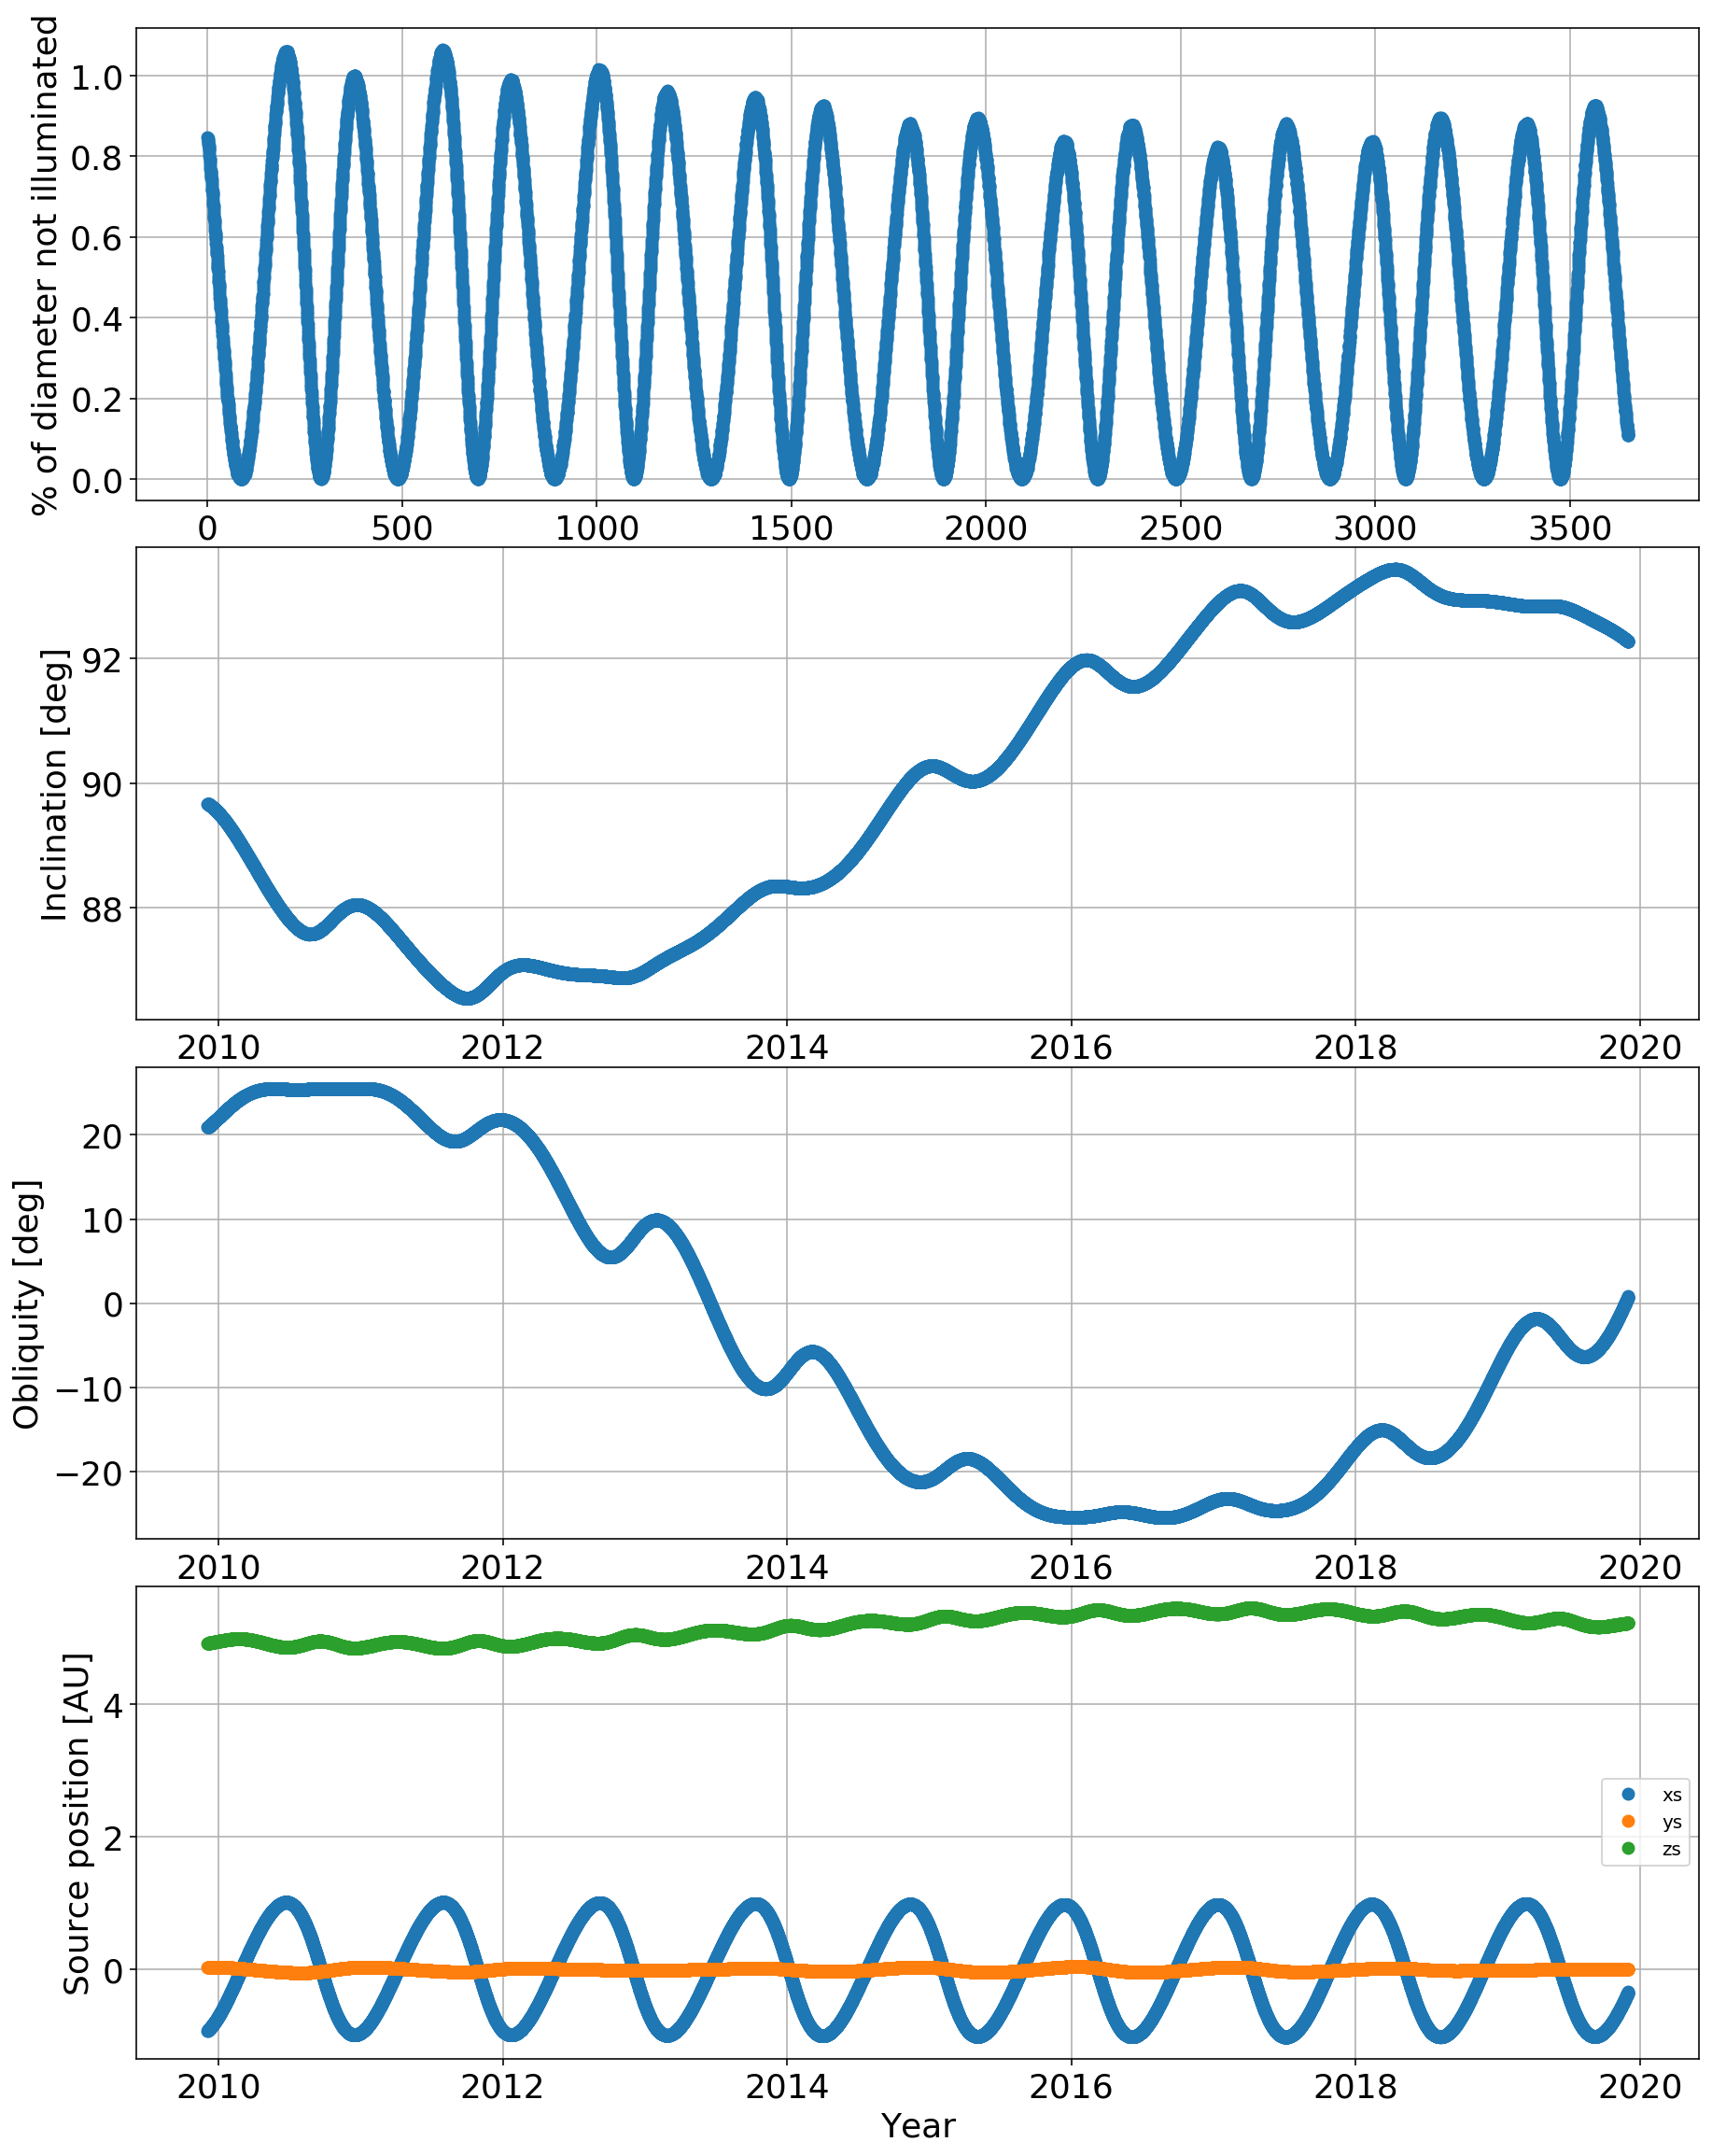

In [22]:
times = Time(
    np.linspace(ts.time.mjd[0], ts.time.mjd[-1] + 10 * 365, 10000), format="mjd"
)
data = get_starry_map_orientation(times, step="1d")

fig, ax = plt.subplots(4, 1, figsize=(15, 20))
fig.subplots_adjust(hspace=0.1)

ax[0].plot(
    data.time.mjd - data.time.mjd[0],
    data["illum_defect"] / data["ang_width"] * 100,
    "C0o",
)
ax[0].set_ylabel("% of diameter not illuminated")

ax[1].plot(data.time.decimalyear, data["inc"], "C0o")
ax[1].set_ylabel("Inclination [deg]")

ax[2].plot(data.time.decimalyear, data["obl"], "C0o")
ax[2].set_ylabel("Obliquity [deg]")
ax[3].plot(data.time.decimalyear, data["xs"], "C0o", label="xs")
ax[3].plot(data.time.decimalyear, data["ys"], "C1o", label="ys")
ax[3].plot(data.time.decimalyear, data["zs"], "C2o", label="zs")
ax[3].legend()
ax[3].set_ylabel("Source position [AU]")


ax[-1].set_xlabel("Year")
for a in ax.flatten():
    a.grid()